# Create dataset

In [1]:
!gdown 1rks7UbT8Bbl7TdQvfqoXx6fXhaPM8xOv

Downloading...
From: https://drive.google.com/uc?id=1rks7UbT8Bbl7TdQvfqoXx6fXhaPM8xOv
To: /content/augmented_kernel_quality.csv
100% 75.8M/75.8M [00:00<00:00, 135MB/s]


In [2]:
import os

api_token = {"username":"_","key":"_"}

import json

with open('kaggle.json', 'w') as file:
  json.dump(api_token, file)

!chmod 600 kaggle.json

In [3]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

## Get code+markdown for 1050 new ground truth

In [4]:
import pandas as pd

df_test = pd.read_csv('experts.csv')
df_test['expert_score'] = df_test['expert_score'].astype(int)


In [6]:
import json
from kaggle import api
import time

codes = []
markdowns = []
errors = []

for i, row in df_test.iterrows():
  try:
    out = api.kernel_pull(row['UserName'], row['CurrentUrlSlug'])
    src = out['blob']['source']
    code = ' \n '.join([x['source'] for x in json.loads(src)['cells'] if x['cell_type'] == 'code'])
    markdown = ' \n '.join([x['source'] for x in json.loads(src)['cells'] if x['cell_type'] == 'markdown'])
    codes.append(code)
    markdowns.append(markdown)
    time.sleep(2)
  except:
    errors.append(i)

In [16]:
notebooks = df_test.copy()
notebooks.index = range(len(df_test))
notebooks = notebooks.drop(errors)
notebooks['code'] = codes
notebooks['markdown'] = markdowns

In [18]:
notebooks[['KernelId', 'code', 'markdown', 'label']].to_csv('1050_train_codebert.csv', index=False)

In [20]:
!cp 1050_train_codebert.csv drive/MyDrive/Meta_Kaggle/

## Get code+markdown for 10k samples

In [4]:
import pandas as pd

kernel_quality = pd.read_csv('augmented_kernel_quality.csv')

In [5]:
kernel_quality = kernel_quality[kernel_quality['TotalViews'] >= 500]

In [6]:
kernel_quality['score'] = (kernel_quality['TotalVotes'] + 1) / kernel_quality['TotalViews']

In [7]:
kernel_quality.sort_values(by=['score'], inplace=True)

In [8]:
sample_len = 10**4
samples = pd.concat([kernel_quality.head(sample_len // 2), kernel_quality.tail(sample_len // 2)])

In [10]:
import json
from kaggle import api
import time

codes = []
markdowns = []
errors = []

for i, row in samples.iterrows():
  try:
    out = api.kernel_pull(row['UserName'], row['CurrentUrlSlug'])
    src = out['blob']['source']
    code = ' \n '.join([x['source'] for x in json.loads(src)['cells'] if x['cell_type'] == 'code'])
    markdown = ' \n '.join([x['source'] for x in json.loads(src)['cells'] if x['cell_type'] == 'markdown'])
    codes.append(code)
    markdowns.append(markdown)
    time.sleep(2)
  except:
    errors.append(i)

In [ ]:
notebooks = samples.copy()
notebooks.index = range(len(samples))
notebooks = notebooks.drop(errors)
notebooks['code'] = codes
notebooks['markdown'] = markdowns

In [46]:
notebooks[['KernelId', 'code', 'markdown', 'score']].to_csv('10000_train_codebert.csv', index=False)

In [47]:
!cp 10000_train_codebert.csv drive/MyDrive/Meta_Kaggle/

# Setup training data

In [1]:
!gdown 15jJ04nVQb3wIGih696kWaizugiyxNKj5

Downloading...
From: https://drive.google.com/uc?id=15jJ04nVQb3wIGih696kWaizugiyxNKj5
To: /content/5000_train_codebert.csv
100% 77.1M/77.1M [00:00<00:00, 123MB/s]


In [2]:
!gdown 1uR9olJJXEpTBEVodeuM-SEgtiMRS9czA

Downloading...
From: https://drive.google.com/uc?id=1uR9olJJXEpTBEVodeuM-SEgtiMRS9czA
To: /content/10000_train_codebert.csv
100% 49.3M/49.3M [00:02<00:00, 21.6MB/s]


In [3]:
import pandas as pd

zeros = pd.read_csv('./10000_train_codebert.csv')
ones = pd.read_csv('./5000_train_codebert.csv')

In [4]:
ones = ones.head(len(zeros))

In [5]:
zeros['label'] = 0
ones['label'] = 1

In [6]:
df = pd.concat([zeros, ones])

In [7]:
df.dropna(subset=['code'], inplace=True)

In [8]:
df.fillna('', inplace=True)

# Train Codebert

## functions and imports

In [9]:
!pip install -q transformers accelerate
!pip install datasets -q
!pip install evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00


In [10]:
import pandas as pd
import numpy as np

import json
import evaluate
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModel
import torch
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

In [ ]:
def create_dataset(data):
  X_train, X_eval, y_train, y_eval = train_test_split(data[['code', 'markdown']], data['label'], test_size=0.10, random_state=1)
  X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
  df_train = pd.DataFrame({'code': X_train['code'], 'markdown': X_train['markdown'], 'label': y_train})
  df_eval = pd.DataFrame({'code': X_eval['code'], 'markdown': X_eval['markdown'], 'label': y_eval})
  df_test = pd.DataFrame({'code': X_test['code'], 'markdown': X_test['markdown'], 'label': y_test})
  dataset = DatasetDict({
      "train": Dataset.from_pandas(df_train),
      "eval": Dataset.from_pandas(df_eval),
      "test": Dataset.from_pandas(df_test),
  })
  return dataset

def tokenize_function(examples):
  markdown_max_len = 300
  truncated_markdown = [markdown[:markdown_max_len] for markdown in examples['markdown']]

  result = tokenizer(
      truncated_markdown,
      examples['code'],
      truncation=True,
      padding='max_length',
      return_tensors='pt',
  )
  return result

def tokenize_dataset(dataset, tokenizer):
  tokenized_dataset = dataset.map(tokenize_function, batched=True)
  return tokenized_dataset

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  metric = evaluate.load("accuracy")
  return metric.compute(predictions=predictions, references=labels)

def create_trainer(tokenized_dataset, model, num_train_epochs, logging_steps):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  for param in model.roberta.parameters():
      param.requires_grad = False

  training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch",
                                    num_train_epochs=num_train_epochs, log_level='debug', logging_steps=logging_steps,)
  training_args.do_predict = True
  training_args.do_train = True
  training_args.do_eval = True
  trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"].shuffle(seed=42),
    eval_dataset=tokenized_dataset["eval"].shuffle(seed=42),
    compute_metrics=compute_metrics,
  )
  return trainer

In [ ]:
model_name = "microsoft/codebert-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

## Chart for accuracy precision recall f1 on test set

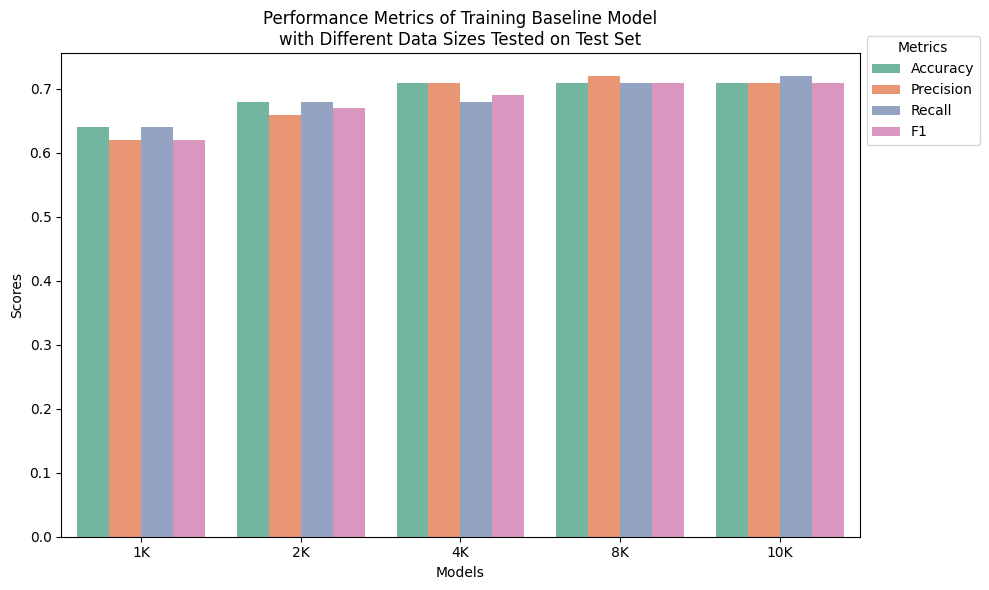

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

models = ['1K', '2K', '4K', '8K', '10K',]
accuracy =  [0.64, 0.68, 0.71, 0.71, 0.71,]
precision = [0.62, 0.66, 0.71, 0.72, 0.71,]
recall =    [0.64, 0.68, 0.68, 0.71, 0.72,]
f1 =        [0.62, 0.67, 0.69, 0.71, 0.71,]

data = pd.DataFrame({'Model': models * 4,
                     'Metric': ['Accuracy'] * 5 + ['Precision'] * 5 + ['Recall'] * 5 + ['F1'] * 5,
                     'Score': accuracy + precision + recall + f1})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=data, palette='Set2')
plt.title('Performance Metrics of Training Baseline Model\nwith Different Data Sizes Tested on Test Set')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend(title='Metrics', bbox_to_anchor=(1, 1.05), loc='upper left')

plt.tight_layout()
plt.show()


## Chart for accuracy precision recall f1 on GT

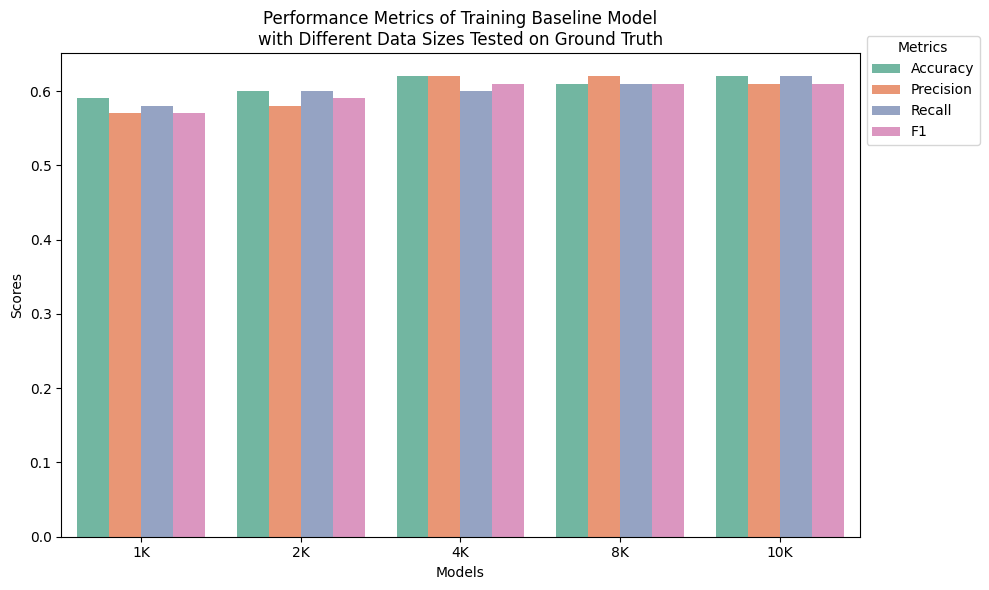

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

models = ['1K', '2K', '4K', '8K', '10K',]
accuracy =  [0.59, 0.60, 0.62, 0.61, 0.62,]
precision = [0.57, 0.58, 0.62, 0.62, 0.61,]
recall =    [0.58, 0.60, 0.60, 0.61, 0.62,]
f1 =        [0.57, 0.59, 0.61, 0.61, 0.61,]

data = pd.DataFrame({'Model': models * 4,
                     'Metric': ['Accuracy'] * 5 + ['Precision'] * 5 + ['Recall'] * 5 + ['F1'] * 5,
                     'Score': accuracy + precision + recall + f1})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=data, palette='Set2')
plt.title('Performance Metrics of Training Baseline Model\nwith Different Data Sizes Tested on Ground Truth')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.legend(title='Metrics', bbox_to_anchor=(1, 1.05), loc='upper left')

plt.tight_layout()
plt.show()


## Load GT

In [ ]:
!gdown 14tqOq2fmW90LhaCpXhRvQstqW1DI9c2S

Downloading...
From: https://drive.google.com/uc?id=14tqOq2fmW90LhaCpXhRvQstqW1DI9c2S
To: /content/1050_train_codebert.csv
100% 15.4M/15.4M [00:00<00:00, 72.6MB/s]


In [ ]:
df_test = pd.read_csv('1050_train_codebert.csv')
df_test.dropna(subset=['code'], inplace=True)
df_test.fillna('', inplace=True)
df_test.dropna(inplace=True)

In [ ]:
df_test_input = pd.DataFrame({'code': df_test['code'], 'markdown': df_test['markdown'], 'label': df_test['label']})
test_dataset = DatasetDict({
  "test": Dataset.from_pandas(df_test_input),
})

tokenized_test_dataset = tokenize_dataset(test_dataset, tokenizer)

## Train with 1k samples

In [ ]:
data = df.sample(1000)
dataset = create_dataset(data)
tokenized_dataset = tokenize_dataset(dataset, tokenizer)
trainer = create_trainer(tokenized_dataset, model, 10, 10)

In [44]:
train_result = trainer.train()

Currently training with a batch size of: 8
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: code, markdown, __index_level_0__. If code, markdown, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 675
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 850
  Number of trainable parameters = 592,130


Epoch,Training Loss,Validation Loss,Accuracy
1,0.692500,0.676775,0.580000
2,0.690400,0.725250,0.420000
3,0.702100,0.668008,0.600000
4,0.681000,0.679526,0.630000
5,0.664200,0.706550,0.420000
6,0.681600,0.659093,0.630000
7,0.666700,0.673682,0.660000
8,0.655700,0.671386,0.670000
9,0.672200,0.675498,0.600000
10,0.650500,0.674204,0.630000


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: code, markdown, __index_level_0__. If code, markdown, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 100
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: code, markdown, __index_level_0__. If code, markdown, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 100
  Batch size = 8
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: code, markdown, __index_level_0__. If code, markdown, __index_level_0

In [45]:
metrics = train_result.metrics
trainer.save_model()  # Saves the tokenizer too for easy upload

trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

Saving model checkpoint to test_trainer
Configuration saved in test_trainer/config.json
Model weights saved in test_trainer/model.safetensors


***** train metrics *****
  epoch                    =       10.0
  total_flos               =  1654028GF
  train_loss               =     0.6817
  train_runtime            = 0:04:38.69
  train_samples_per_second =      24.22
  train_steps_per_second   =       3.05


In [46]:
# Evaluation

metrics = trainer.evaluate(eval_dataset=tokenized_dataset["eval"].shuffle(seed=42))

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: code, markdown, __index_level_0__. If code, markdown, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 100
  Batch size = 8


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =       0.63
  eval_loss               =     0.6742
  eval_runtime            = 0:00:03.35
  eval_samples_per_second =     29.786
  eval_steps_per_second   =      3.872


In [47]:
# Prediction

predictions, labels, metrics = trainer.predict(tokenized_dataset["test"], metric_key_prefix="predict")

trainer.log_metrics("predict", metrics)
trainer.save_metrics("predict", metrics)

predictions = np.argmax(predictions, axis=1)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: code, markdown, __index_level_0__. If code, markdown, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 225
  Batch size = 8


***** predict metrics *****
  predict_accuracy           =       0.64
  predict_loss               =     0.6621
  predict_runtime            = 0:00:07.79
  predict_samples_per_second =     28.847
  predict_steps_per_second   =      3.718


In [48]:
print(classification_report(predictions, labels, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.46      0.64      0.53        72
           1       0.79      0.64      0.71       153

    accuracy                           0.64       225
   macro avg       0.62      0.64      0.62       225
weighted avg       0.68      0.64      0.65       225



## Train with 2k samples

In [ ]:
data = df.sample(2000)
dataset = create_dataset(data)
tokenized_dataset = tokenize_dataset(dataset, tokenizer)
trainer = create_trainer(tokenized_dataset, model, 10, 10)

In [ ]:
train_result = trainer.train()

Currently training with a batch size of: 8
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, code, markdown. If __index_level_0__, code, markdown are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1,350
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1,690
  Number of trainable parameters = 592,130


Epoch,Training Loss,Validation Loss,Accuracy
1,0.689400,0.704932,0.445000
2,0.685000,0.675178,0.555000
3,0.680200,0.661891,0.665000
4,0.659300,0.667012,0.640000
5,0.645700,0.647279,0.635000
6,0.676200,0.644324,0.590000
7,0.647600,0.652114,0.655000
8,0.629100,0.642429,0.670000
9,0.645200,0.638015,0.670000
10,0.656600,0.639712,0.675000


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, code, markdown. If __index_level_0__, code, markdown are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 8


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, code, markdown. If __index_level_0__, code, markdown are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 8
Saving model checkpoint to test_trainer/tmp-checkpoint-500
Configuration saved in test_trainer/tmp-checkpoint-500/config.json
Model weights saved in test_trainer/tmp-checkpoint-500/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, code, markdown. If __index_level_0__, code, markdown are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 8
The following colum

In [ ]:
metrics = train_result.metrics
trainer.save_model()  # Saves the tokenizer too for easy upload

trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

# Evaluation

metrics = trainer.evaluate(eval_dataset=tokenized_dataset["eval"].shuffle(seed=42))

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

# Prediction

predictions, labels, metrics = trainer.predict(tokenized_dataset["test"], metric_key_prefix="predict")

trainer.log_metrics("predict", metrics)
trainer.save_metrics("predict", metrics)

predictions = np.argmax(predictions, axis=1)

print(classification_report(predictions, labels, labels=[0, 1]))

Saving model checkpoint to test_trainer
Configuration saved in test_trainer/config.json
Model weights saved in test_trainer/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, code, markdown. If __index_level_0__, code, markdown are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 8


***** train metrics *****
  epoch                    =       10.0
  total_flos               =  3308057GF
  train_loss               =     0.6638
  train_runtime            = 0:09:22.65
  train_samples_per_second =     23.993
  train_steps_per_second   =      3.004


The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, code, markdown. If __index_level_0__, code, markdown are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 450
  Batch size = 8


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =      0.675
  eval_loss               =     0.6397
  eval_runtime            = 0:00:07.60
  eval_samples_per_second =     26.308
  eval_steps_per_second   =      3.289
***** predict metrics *****
  predict_accuracy           =     0.6844
  predict_loss               =     0.6351
  predict_runtime            = 0:00:16.00
  predict_samples_per_second =     28.109
  predict_steps_per_second   =       3.56
              precision    recall  f1-score   support

           0       0.70      0.71      0.71       240
           1       0.67      0.65      0.66       210

    accuracy                           0.68       450
   macro avg       0.68      0.68      0.68       450
weighted avg       0.68      0.68      0.68       450



### Test with GT

In [ ]:
predictions, labels, metrics = trainer.predict(tokenized_test_dataset['test'], metric_key_prefix="predict")

trainer.log_metrics("predict", metrics)
trainer.save_metrics("predict", metrics)

predictions = np.argmax(predictions, axis=1)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, code, markdown. If __index_level_0__, code, markdown are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 991
  Batch size = 8


***** predict metrics *****
  predict_accuracy           =     0.5954
  predict_loss               =     0.6642
  predict_runtime            = 0:00:36.60
  predict_samples_per_second =     27.076
  predict_steps_per_second   =      3.388


In [ ]:
print(classification_report(predictions, labels, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.56      0.61      0.58       465
           1       0.63      0.59      0.61       526

    accuracy                           0.60       991
   macro avg       0.60      0.60      0.60       991
weighted avg       0.60      0.60      0.60       991



## Train with 4k samples

In [ ]:
data = df.sample(4000)
dataset = create_dataset(data)
tokenized_dataset = tokenize_dataset(dataset, tokenizer)
trainer = create_trainer(tokenized_dataset, model, 10, 10)

In [ ]:
train_result = trainer.train()

Currently training with a batch size of: 8
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, code, markdown. If __index_level_0__, code, markdown are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 2,700
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3,380
  Number of trainable parameters = 592,130


Epoch,Training Loss,Validation Loss,Accuracy
1,0.672800,0.671799,0.522500
2,0.644700,0.647652,0.662500
3,0.688100,0.648802,0.592500
4,0.711300,0.626143,0.655000
5,0.668600,0.613160,0.670000
6,0.623700,0.604414,0.690000
7,0.629300,0.598861,0.695000
8,0.593200,0.618031,0.652500
9,0.600400,0.592445,0.712500
10,0.593000,0.590288,0.722500


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, code, markdown. If __index_level_0__, code, markdown are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 8
Checkpoint destination directory test_trainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, code, markdown. If __index_level_0__, code, markdown are not expected by `RobertaForSequenceClassification

In [ ]:
metrics = train_result.metrics
trainer.save_model()  # Saves the tokenizer too for easy upload

trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

# Evaluation

metrics = trainer.evaluate(eval_dataset=tokenized_dataset["eval"].shuffle(seed=42))

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

# Prediction

predictions, labels, metrics = trainer.predict(tokenized_dataset["test"], metric_key_prefix="predict")

trainer.log_metrics("predict", metrics)
trainer.save_metrics("predict", metrics)

predictions = np.argmax(predictions, axis=1)

print(classification_report(predictions, labels, labels=[0, 1]))

Saving model checkpoint to test_trainer
Configuration saved in test_trainer/config.json
Model weights saved in test_trainer/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: code, markdown, __index_level_0__. If code, markdown, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 8


***** train metrics *****
  epoch                    =       10.0
  total_flos               =  6616114GF
  train_loss               =     0.6452
  train_runtime            = 0:19:27.88
  train_samples_per_second =     23.119
  train_steps_per_second   =      2.894


The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: code, markdown, __index_level_0__. If code, markdown, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 900
  Batch size = 8


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =       0.68
  eval_loss               =     0.6137
  eval_runtime            = 0:00:14.60
  eval_samples_per_second =     27.389
  eval_steps_per_second   =      3.424
***** predict metrics *****
  predict_accuracy           =     0.7078
  predict_loss               =     0.5996
  predict_runtime            = 0:00:32.51
  predict_samples_per_second =     27.678
  predict_steps_per_second   =      3.475
              precision    recall  f1-score   support

           0       0.72      0.71      0.72       470
           1       0.69      0.70      0.70       430

    accuracy                           0.71       900
   macro avg       0.71      0.71      0.71       900
weighted avg       0.71      0.71      0.71       900



### Test with GT

In [ ]:
predictions, labels, metrics = trainer.predict(tokenized_test_dataset['test'], metric_key_prefix="predict")

trainer.log_metrics("predict", metrics)
trainer.save_metrics("predict", metrics)

predictions = np.argmax(predictions, axis=1)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, code, markdown. If __index_level_0__, code, markdown are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 991
  Batch size = 8


***** predict metrics *****
  predict_accuracy           =     0.6186
  predict_loss               =     0.6515
  predict_runtime            = 0:00:36.35
  predict_samples_per_second =     27.255
  predict_steps_per_second   =       3.41


In [ ]:
print(classification_report(predictions, labels, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.59      0.63      0.61       464
           1       0.65      0.61      0.63       527

    accuracy                           0.62       991
   macro avg       0.62      0.62      0.62       991
weighted avg       0.62      0.62      0.62       991



## Train with 8k samples

In [ ]:
data = df.sample(8000)
dataset = create_dataset(data)
tokenized_dataset = tokenize_dataset(dataset, tokenizer)
trainer = create_trainer(tokenized_dataset, model, 10, 10)

In [ ]:
train_result = trainer.train()

Currently training with a batch size of: 8
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, code, markdown. If __index_level_0__, code, markdown are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 5,400
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6,750
  Number of trainable parameters = 592,130


Epoch,Training Loss,Validation Loss,Accuracy
1,0.626000,0.596924,0.670000
2,0.576300,0.587207,0.696250
3,0.610000,0.571790,0.681250
4,0.551500,0.586806,0.683750
5,0.532700,0.611897,0.655000
6,0.649500,0.589258,0.681250
7,0.643400,0.556786,0.705000
8,0.642700,0.555304,0.702500
9,0.598000,0.556167,0.705000


Checkpoint destination directory test_trainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, code, markdown. If __index_level_0__, code, markdown are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 8
Checkpoint destination directory test_trainer/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model

In [ ]:
metrics = train_result.metrics
trainer.save_model()  # Saves the tokenizer too for easy upload

trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

# Evaluation

metrics = trainer.evaluate(eval_dataset=tokenized_dataset["eval"].shuffle(seed=42))

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

# Prediction

predictions, labels, metrics = trainer.predict(tokenized_dataset["test"], metric_key_prefix="predict")

trainer.log_metrics("predict", metrics)
trainer.save_metrics("predict", metrics)

predictions = np.argmax(predictions, axis=1)

print(classification_report(predictions, labels, labels=[0, 1]))

Saving model checkpoint to test_trainer
Configuration saved in test_trainer/config.json
Model weights saved in test_trainer/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: code, markdown, __index_level_0__. If code, markdown, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 8


***** train metrics *****
  epoch                    =       10.0
  total_flos               = 13232228GF
  train_loss               =     0.6248
  train_runtime            = 0:38:51.35
  train_samples_per_second =     23.163
  train_steps_per_second   =      2.895


The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: code, markdown, __index_level_0__. If code, markdown, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1800
  Batch size = 8


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =       0.68
  eval_loss               =      0.577
  eval_runtime            = 0:00:29.03
  eval_samples_per_second =     27.553
  eval_steps_per_second   =      3.444
***** predict metrics *****
  predict_accuracy           =     0.7144
  predict_loss               =     0.5674
  predict_runtime            = 0:01:04.11
  predict_samples_per_second =     28.077
  predict_steps_per_second   =       3.51
              precision    recall  f1-score   support

           0       0.69      0.72      0.71       861
           1       0.74      0.71      0.72       939

    accuracy                           0.71      1800
   macro avg       0.71      0.71      0.71      1800
weighted avg       0.72      0.71      0.71      1800



### Test with GT

In [ ]:
predictions, labels, metrics = trainer.predict(tokenized_test_dataset['test'], metric_key_prefix="predict")

trainer.log_metrics("predict", metrics)
trainer.save_metrics("predict", metrics)

predictions = np.argmax(predictions, axis=1)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, code, markdown. If __index_level_0__, code, markdown are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 991
  Batch size = 8


Epoch,Training Loss,Validation Loss,Accuracy
1,0.662100,0.647064,0.667500
2,0.643900,0.627734,0.651250
3,0.626600,0.600095,0.687500
4,0.651900,0.610050,0.660000
5,0.600300,0.625951,0.628750


***** predict metrics *****
  predict_accuracy           =     0.6115
  predict_loss               =      0.655
  predict_runtime            = 0:00:34.71
  predict_samples_per_second =     28.548
  predict_steps_per_second   =      3.572


In [ ]:
print(classification_report(predictions, labels, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.59      0.62      0.61       477
           1       0.63      0.60      0.62       514

    accuracy                           0.61       991
   macro avg       0.61      0.61      0.61       991
weighted avg       0.61      0.61      0.61       991



## Train with 10k samples

In [50]:
data = df.copy()
dataset = create_dataset(data)
tokenized_dataset = tokenize_dataset(dataset, tokenizer)
trainer = create_trainer(tokenized_dataset, model, 10, 10)

In [69]:
train_result = trainer.train()

Currently training with a batch size of: 8
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: code, markdown, __index_level_0__. If code, markdown, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 6,424
  Num Epochs = 40
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32,120
  Number of trainable parameters = 592,130


Epoch,Training Loss,Validation Loss,Accuracy
1,0.665500,0.631581,0.696429
2,0.617800,0.631441,0.632353
3,0.630900,0.583330,0.700630
4,0.582700,0.574614,0.702731
5,0.602200,0.568319,0.700630
6,0.613800,0.583655,0.703782
7,0.607700,0.569142,0.720588
8,0.631700,0.565123,0.718487
9,0.566700,0.573619,0.714286
10,0.597900,0.554583,0.715336


Checkpoint destination directory test_trainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/model.safetensors
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: code, markdown, __index_level_0__. If code, markdown, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 952
  Batch size = 8
Saving model checkpoint to test_trainer/tmp-checkpoint-1000
Configuration saved in test_trainer/tmp-checkpoint-1000/config.json
Model weights saved in test_trainer/tmp-checkpoint-1000/model.safetensors
Saving model checkpoint to test_trainer/tmp-checkpoint-1500
Configuratio

KeyboardInterrupt: 

In [70]:
metrics = train_result.metrics
trainer.save_model()  # Saves the tokenizer too for easy upload

trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

Saving model checkpoint to test_trainer
Configuration saved in test_trainer/config.json
Model weights saved in test_trainer/model.safetensors


***** train metrics *****
  epoch                    =       10.0
  total_flos               =  1654028GF
  train_loss               =     0.6817
  train_runtime            = 0:04:38.69
  train_samples_per_second =      24.22
  train_steps_per_second   =       3.05


In [71]:
# Evaluation

metrics = trainer.evaluate(eval_dataset=tokenized_dataset["eval"].shuffle(seed=42))

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: code, markdown, __index_level_0__. If code, markdown, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 952
  Batch size = 8


Epoch,Training Loss,Validation Loss,Accuracy
1,0.665500,0.631581,0.696429
2,0.617800,0.631441,0.632353
3,0.630900,0.583330,0.700630
4,0.582700,0.574614,0.702731
5,0.602200,0.568319,0.700630
6,0.613800,0.583655,0.703782
7,0.607700,0.569142,0.720588
8,0.631700,0.565123,0.718487
9,0.566700,0.573619,0.714286
10,0.597900,0.554583,0.715336


***** eval metrics *****
  eval_accuracy = 0.7153
  eval_loss     = 0.5502


In [72]:
# Prediction

predictions, labels, metrics = trainer.predict(tokenized_dataset["test"], metric_key_prefix="predict")

trainer.log_metrics("predict", metrics)
trainer.save_metrics("predict", metrics)

predictions = np.argmax(predictions, axis=1)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: code, markdown, __index_level_0__. If code, markdown, __index_level_0__ are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2142
  Batch size = 8


Epoch,Training Loss,Validation Loss,Accuracy
1,0.665500,0.631581,0.696429
2,0.617800,0.631441,0.632353
3,0.630900,0.583330,0.700630
4,0.582700,0.574614,0.702731
5,0.602200,0.568319,0.700630
6,0.613800,0.583655,0.703782
7,0.607700,0.569142,0.720588
8,0.631700,0.565123,0.718487
9,0.566700,0.573619,0.714286
10,0.597900,0.554583,0.715336


***** predict metrics *****
  predict_accuracy           =     0.7092
  predict_loss               =     0.5461
  predict_runtime            = 0:01:11.71
  predict_samples_per_second =     29.868
  predict_steps_per_second   =      3.737


In [73]:
print(classification_report(predictions, labels, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.82      0.67      0.73      1285
           1       0.61      0.77      0.68       857

    accuracy                           0.71      2142
   macro avg       0.71      0.72      0.71      2142
weighted avg       0.73      0.71      0.71      2142

